# Example of Browsing the ASE SQLite Database

The notebook provides an overview of browsing an [ASE SQLite3 database](https://wiki.fysik.dtu.dk/ase/ase/db/db.html). 
It covers connecting to the database, retrieving metadata, listing keys and descriptions, exploring possible values, accessing specific systems, and utilizing ASE functionality for analysis and visualization. 

Import needed libraries for this notebook.

In [133]:
import sys
import os
import ase
from ase.db import connect
import pandas as pd

import matplotlib.pyplot as plt

# add father folder to allow to access the modules of this repository in `..\tools`
sys.path.append('..') 
from tools.db import get_yaml_metadata, get_unique_values

plt.style.use("default") # Set defoult style

## Load database

The code below connects to the database and retrieves metadata from the YAML file. 

It then prints the total number of systems stored in the database and lists the keys along with their descriptions.

In [134]:
# Connect to the database
db = connect(os.path.join("..", "data", "LiF.db"))

# Get metadata from the YAML file
metadata = get_yaml_metadata(os.path.join("..", "data", "LiF.yaml"))

In [135]:
# Print the total number of systems stored in the database
print(f"Total systems stored: {len(db):d}", end="\n\n")

# Print the keys and their descriptions
print("KEY".ljust(15)  + "| " + "DESCRIPTION")
print("-"*15 + "|" + "-"*104)
for k,v in metadata['keys'].items():
    print(f"{k}".ljust(15) +'| ' + v['description'])
    

Total systems stored: 706

KEY            | DESCRIPTION
---------------|--------------------------------------------------------------------------------------------------------
id             | Uniqe row ID
ctime          | Creation time of the data (for simulation it coincide with the runtime)
formula        | Chemical formula of the system
pbc            | Periodic boundary conditions
user           | Username or full name of the user who created the data
calculator     | ASE-calculator name
energy         | Total energy of the system from the calculation
natoms         | Number of atoms
fmax           | Maximum force
smax           | Maximum stress on unit cell
charge         | Net charge in unit cell
mass           | Sum of atomic masses in unit cell
magmom         | Magnetic moment
unique_id      | Random (unique) ID
volume         | Volume of unit cell
functional     | Exchange-and-correlation functional
fermi_energy   | Fermi Energy (N.B. is not the Fermi Level), which indicates

## Select and get stored `Atoms`

The code below checks if there are fixed lists of values for the `subset_name`, `task`, and `space_group` keys. It prints the fixed values if they exist.

In [136]:
# Check if there are fixed lists of values for specific keys
for key in ['subset_name', 'task', 'space_group']:
    value = metadata['keys'][key]['values']
    if isinstance(value, str):
        print(f'{key:<10s}: {value}')
    elif isinstance(value, dict):
        print(f'{key:<10s}: {list(value.keys())}')


subset_name: ['ab-initio md 300K', 'ab-initio md 500K', 'ab-initio md amorphous crystal', 'interstitial defects', 'pure elements unit cell', 'slabs', 'strained lattice', 'substitutional defects', 'supercell', 'unit cell', 'vacancy defects']
task      : ['geometry optimization', 'geometry pre-optimization', 'initial configuration', 'single point']
space_group: The space group notation in a LaTeX-like string, with screw axes being represented by an underscore. (see pymatgen.symmetry.groups.SpaceGroup (https://pymatgen.org/pymatgen.symmetry.groups.html#pymatgen.symmetry.groups.SpaceGroup))


Because there is not a list of possible value for the `space_group` we can tray to get directly from the database.

The following code retrieves the unique values for the `space_group` key directly from the database using `get_unique_values` provided function.

In [137]:
# Get unique values for 'space_group' directly from the database
get_unique_values(db, 'space_group')

['C2c', 'Fm-3m', 'P6_3mc', 'Pm-3m', 'R-3m']

Now using the database method `select`, we are getting the desired rows from which we are getting the desired systems as ASE `Atoms` and storing them into a `list.`

In [138]:
# Get desired systems from the database and store them in a list
selection = []
for row in db.select(subset_name='interstitial defects', task='geometry optimization', space_group='Fm-3m'):
    selection.append(row.toatoms(add_additional_information=True))


## Exemple of `Atoms` manipulation

Now we can use alle the methods and function of the ASE library `Atoms` (for more info see https://wiki.fysik.dtu.dk/ase/index.html).

For example the following code demonstrates accessing the ASE Atoms object from the selection and getting the calculated energy for a specific system.

In [139]:
# Access ASE Atoms and retrieve calculated energy
atoms = selection[0]
print(f"Tot. Energy for system {atoms.info['key_value_pairs']['name']}:\t{atoms.get_total_energy()} eV")

Tot. Energy for system 5.0-0-LiF_Fm-3m_-3.18_ni_0:	-115.49074518921543 eV


Using ASE visualizer we can display the ending geometry of the simulation.

In [140]:
# Visualize the ending geometry of the simulation using ASE visualizer
from ase.visualize import view
view(atoms, viewer='ngl')

We can access all the additional data from the `Atoms` attribute `info`.
For example, in the following code, we are going to access and plot the Density of States (DOS) stored in `data`.

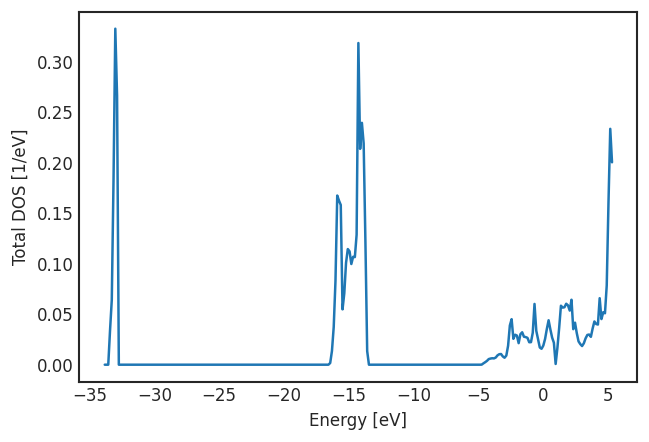

In [144]:
# Plot the Density of States (DOS) stored in the 'info' attribute of Atoms
energy = atoms.info['data']['DOS']['Energy [eV]']
dos = atoms.info['data']['DOS']['Total DOS [1/eV]']

fig = plt.figure(figsize=[6, 4], dpi=120, facecolor="white")

with plt.style.context("seaborn-v0_8-white"):
    ax = fig.add_subplot(111)
    ax.plot(energy, dos)
    ax.set_ylabel('Total DOS [1/eV]')
    ax.set_xlabel('Energy [eV]')

plt.show()
